In [2]:
# Import dependencies

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.svm import SVC
from itertools import combinations
from sklearn.decomposition import PCA

In [3]:
# Read in processed data
file_path = '/Users/ruthwalters/Library/CloudStorage/Dropbox/FALL 2025/Machine learning/Projects/proj1/data/processed_data/processed_project_adult.csv'
data = pd.read_csv(file_path, index_col=0)

# Separate target values
X = data.drop(columns=['income'], axis=1)
y = data[['income']]

# Split data into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

## Support vector machine

### Plotting functions

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from itertools import combinations
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def plot_svm_decision_boundaries_multi_feature(X, y, kernels, title_prefix="", C=1.0, gamma='scale'):
    """
    Plots the decision boundaries for multiple SVM models and multiple feature pairs,
    automatically handling non-numerical target labels and different data types for y.

    Args:
        X (pd.DataFrame): The input features (must have at least 2 columns).
        y (pd.Series or np.ndarray or pd.DataFrame): The target labels.
        kernels (list): A list of kernel strings (e.g., 'linear', 'rbf', 'poly').
        title_prefix (str): A prefix for the plot titles.
        C (float): The regularization parameter.
        gamma (str or float): Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.
    """
    # Standardize the y input to a pandas Series
    if isinstance(y, pd.DataFrame):
        if y.shape[1] != 1:
            raise ValueError("If 'y' is a DataFrame, it must contain a single column.")
        y_series = y.iloc[:, 0]
    elif isinstance(y, (pd.Series, np.ndarray)):
        # Convert to Series for consistent handling, and ravel to ensure 1D
        y_series = pd.Series(y).ravel()
    else:
        raise TypeError("y must be a pandas DataFrame, Series, or a NumPy array.")

    # Check the dtype of the uniform y_series and encode if necessary
    if y_series.dtype == 'object':
        print("Encoding string labels to numerical format...")
        le = LabelEncoder()
        y_encoded = le.fit_transform(y_series)
    else:
        y_encoded = y_series.values

    n_features = X.shape[1]
    if n_features < 2:
        raise ValueError("This function requires at least 2 features for plotting combinations.")

    feature_pairs = list(combinations(range(n_features), 2))
    n_pairs = len(feature_pairs)
    n_kernels = len(kernels)

    fig, axes = plt.subplots(n_kernels, n_pairs, figsize=(n_pairs * 6, n_kernels * 5),
                             constrained_layout=True)

    # Ensure axes is a 2D array even for a single row/column
    if n_kernels == 1 and n_pairs == 1:
        axes = np.array([[axes]])
    elif n_kernels == 1:
        axes = np.array([axes])
    elif n_pairs == 1:
        axes = axes.reshape(-1, 1)

    for i, kernel in enumerate(kernels):
        for j, (f1_idx, f2_idx) in enumerate(feature_pairs):
            ax = axes[i, j]

            # Select the two features for the current plot
            X_pair = X.iloc[:, [f1_idx, f2_idx]]
            f1_name = X.columns[f1_idx]
            f2_name = X.columns[f2_idx]

            # Train the SVM model on the selected features
            if kernel == 'poly':
                model = SVC(kernel=kernel, C=C, gamma=gamma, degree=3)
            else:
                model = SVC(kernel=kernel, C=C, gamma=gamma)
            
            # FIT THE MODEL WITH .values TO AVOID THE WARNING
            model.fit(X_pair.values, y_encoded)

            # Plot the data points with encoded labels
            ax.scatter(X_pair.iloc[:, 0], X_pair.iloc[:, 1], c=y_encoded, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

            # Create and plot the decision boundary
            xlim = ax.get_xlim()
            ylim = ax.get_ylim()
            xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 500),
                                 np.linspace(ylim[0], ylim[1], 500))
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)

            ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
            
            # Highlight the support vectors
            ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100,
                       linewidth=1, facecolors='none', edgecolors='k')
            
            # Set titles and labels
            ax.set_title(f"{title_prefix} {kernel.capitalize()} ({f1_name} vs {f2_name})")
            ax.set_xlabel(f1_name)
            ax.set_ylabel(f2_name)
            ax.set_aspect('equal', adjustable='box')

    plt.show()

In [23]:
def plot_best_svm_decision_boundary(grid_search, X, y):
    """
    Plots the decision boundaries for the best SVM model found by GridSearchCV.

    Args:
        grid_search (GridSearchCV): The fitted GridSearchCV object.
        X (pd.DataFrame): The input features (must be a DataFrame for feature names).
        y (pd.Series or np.ndarray): The target labels.
    """
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_kernel = best_params.get('kernel', 'linear') # Default to linear if not found

    # Standardize the y input and encode if necessary
    if isinstance(y, pd.DataFrame):
        if y.shape[1] != 1:
            raise ValueError("If 'y' is a DataFrame, it must contain a single column.")
        y_series = y.iloc[:, 0]
    elif isinstance(y, (pd.Series, np.ndarray)):
        y_series = pd.Series(y).ravel()
    else:
        raise TypeError("y must be a pandas DataFrame, Series, or a NumPy array.")
    
    if y_series.dtype == 'object':
        print("Encoding string labels to numerical format...")
        le = LabelEncoder()
        y_encoded = le.fit_transform(y_series)
    else:
        y_encoded = y_series.values

    n_features = X.shape[1]
    if n_features < 2:
        raise ValueError("This function requires at least 2 features for plotting combinations.")

    feature_pairs = list(combinations(range(n_features), 2))
    n_pairs = len(feature_pairs)
    
    fig, axes = plt.subplots(1, n_pairs, figsize=(n_pairs * 6, 6), constrained_layout=True)

    # Ensure axes is an array even for a single subplot
    if n_pairs == 1:
        axes = [axes]

    for j, (f1_idx, f2_idx) in enumerate(feature_pairs):
        print("iter")
        ax = axes[j]
        
        # Select the two features for the current plot
        X_pair = X.iloc[:, [f1_idx, f2_idx]]
        f1_name = X.columns[f1_idx]
        f2_name = X.columns[f2_idx]

        # Use the best model from GridSearchCV
        model = best_model
        
        # Since the best model was trained on the full dataset, we'll retrain
        # a new instance of it on just the two features for plotting purposes.
        # This is the most reliable way to ensure the decision boundary is correct.
        plot_model = SVC(
            kernel=best_params.get('kernel'),
            C=best_params.get('C'),
            gamma=best_params.get('gamma')
        )
        if best_kernel == 'poly':
            plot_model.degree = best_params.get('degree', 3) # Handle poly degree separately
        plot_model.fit(X_pair.values, y_encoded)
        
        # Plot the data points
        ax.scatter(X_pair.iloc[:, 0], X_pair.iloc[:, 1], c=y_encoded, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

        # Create and plot the decision boundary
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 500),
                             np.linspace(ylim[0], ylim[1], 500))
        Z = plot_model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
        
        # Highlight the support vectors
        ax.scatter(plot_model.support_vectors_[:, 0], plot_model.support_vectors_[:, 1], s=100,
                   linewidth=1, facecolors='none', edgecolors='k')
        
        # Set titles and labels
        ax.set_title(f"Best Model ({best_kernel.capitalize()} kernel)\n({f1_name} vs {f2_name})")
        ax.set_xlabel(f1_name)
        ax.set_ylabel(f2_name)
        ax.set_aspect('equal', adjustable='box')

    plt.suptitle(f"GridSearchCV Best Model Decision Boundaries\nBest Params: {best_params}", y=1.05)
    plt.show()

### Initial model implementation

In [4]:
# Train with linear kernel
model = SVC(kernel='linear', C=1)
model.fit(X_train, y_train.values.ravel())

# Make predictions on the scaled test set.
y_pred = model.predict(X_test)

In [5]:
# Generate and display the confusion matrix and classification report
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))


--- Classification Report ---
              precision    recall  f1-score   support

       <=50K       0.82      0.97      0.89      4945
        >50K       0.79      0.33      0.47      1567

    accuracy                           0.82      6512
   macro avg       0.80      0.65      0.68      6512
weighted avg       0.81      0.82      0.79      6512



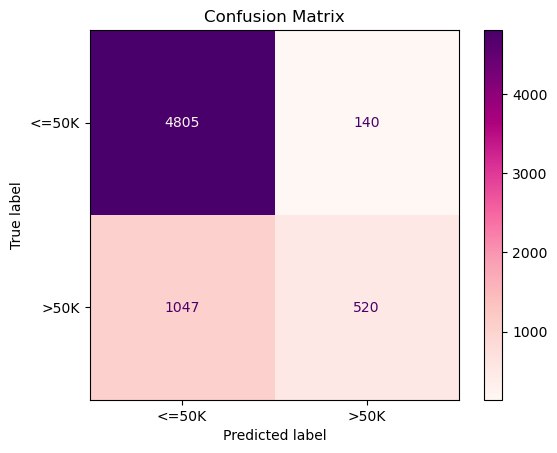

In [6]:
disp = ConfusionMatrixDisplay.from_estimator(
    model,          # your trained model
    X_test,              # test features
    y_test,              # test labels
    display_labels=np.unique(y_test),  # or custom class names like ["<=50K", ">50K"]
    cmap=plt.cm.RdPu     # normalize rows to proportions
)

plt.title('Confusion Matrix')
plt.show()

### Hyperparameter tuning

In [9]:
# evil
# plot_svm_decision_boundaries_multi_feature(X_train, y_train, kernels=['linear', 'rbf', 'poly'])

In [9]:
# We use GridSearchCV to find the best hyperparameters for the model.
# Cross-validation (CV) helps to get a more robust estimate of model performance
# and prevents overfitting to a single train-test split.

# Define the parameter grid to search over.
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}


# Initialize RandomizedSearchCV with 5-fold CV
random_search = RandomizedSearchCV(
    estimator=SVC(),
    param_distributions=param_grid,
    n_iter=10,                # Number of random combinations to try (adjust as needed)
    cv=5,                     # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    random_state=42           # For reproducibility
)

print("Starting randomized hyperparameter search...")
random_search.fit(X_train, y_train.values.ravel())

Starting randomized hyperparameter search...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10],
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['linear', 'rbf']},
                   random_state=42, scoring='accuracy', verbose=1)

In [10]:
# Get the best estimator from the search.
best_model = random_search.best_estimator_

print("\n--- Best Model Found by GridSearchCV ---")
print(f"Best parameters: {random_search.best_params_}")
print(f"Best cross-validation accuracy: {random_search.best_score_:.4f}")


--- Best Model Found by GridSearchCV ---
Best parameters: {'kernel': 'rbf', 'gamma': 'auto', 'C': 1}
Best cross-validation accuracy: 0.8465


In [11]:
print("\n Final evaluation of the best model on the test set...")
# Predict using the best model found during the search.
final_y_pred = best_model.predict(X_test)
final_accuracy = accuracy_score(y_test, final_y_pred)

print(f"Final accuracy on test set: {final_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, final_y_pred))


 Final evaluation of the best model on the test set...
Final accuracy on test set: 0.8398

Classification Report:
              precision    recall  f1-score   support

       <=50K       0.86      0.94      0.90      4945
        >50K       0.74      0.51      0.61      1567

    accuracy                           0.84      6512
   macro avg       0.80      0.73      0.75      6512
weighted avg       0.83      0.84      0.83      6512



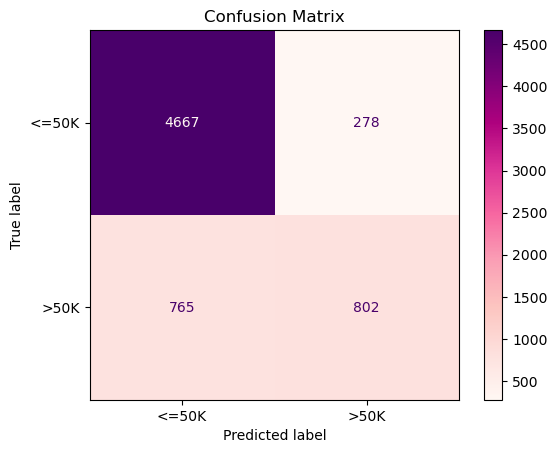

In [12]:
disp = ConfusionMatrixDisplay.from_estimator(
    best_model,
    X_test,
    y_test,
    display_labels=np.unique(y_test),  
    cmap=plt.cm.RdPu    # normalize rows to proportions
)

plt.title('Confusion Matrix')
plt.show()

Encoding string labels to numerical format...
iter
iter
iter
iter
iter


KeyboardInterrupt: 

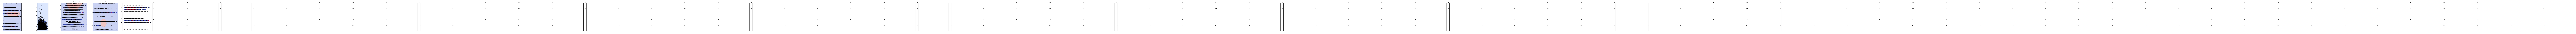

In [24]:
# Plot decision boundaries for selected
plot_best_svm_decision_boundary(random_search, X_train, y_train)

### Principal component analysis

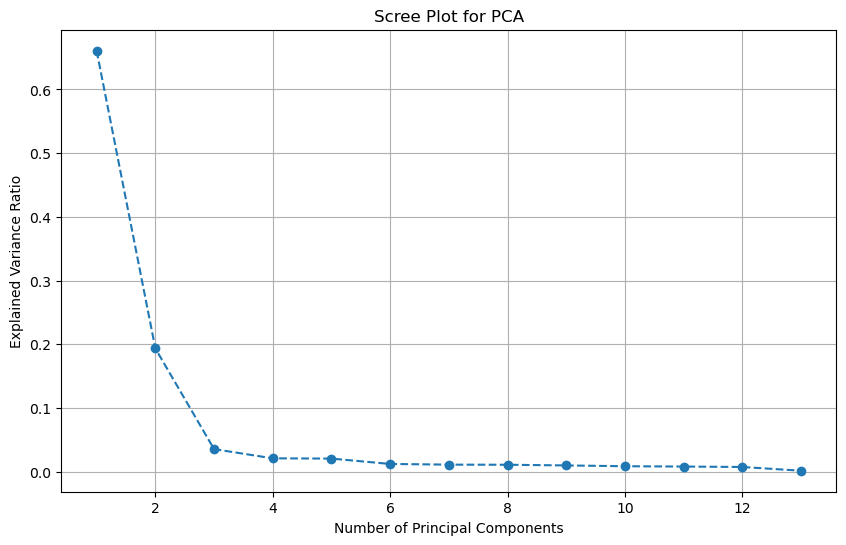

In [25]:
# Perform PCA without assuming a fixed number of components
# By default, PCA will compute all n_features components.
pca = PCA()
pca.fit(X_train) # this is on x train to compare performance 

plt.figure(figsize=(10, 6))
explained_variance_ratio = pca.explained_variance_ratio_
components = range(1, len(explained_variance_ratio) + 1)
plt.plot(components, explained_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot for PCA')
plt.grid(True)
plt.show()

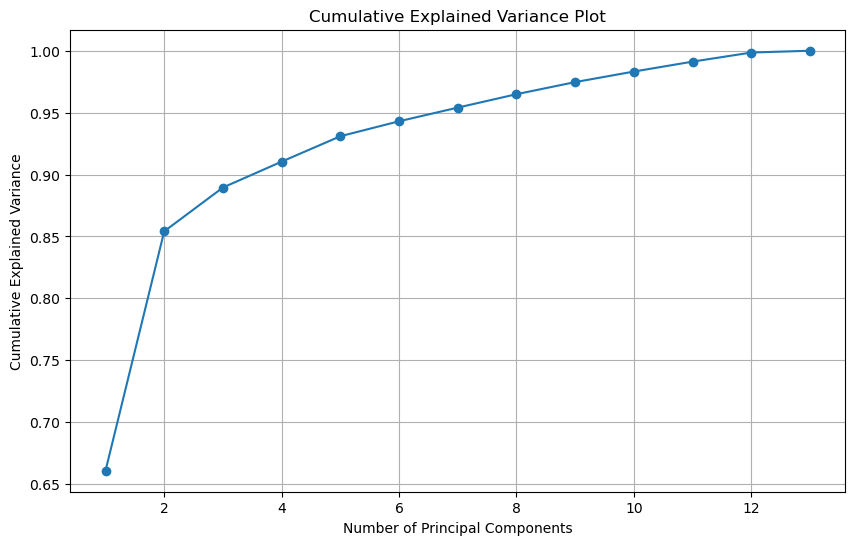

In [26]:
# reate the Cumulative Explained Variance Plot
plt.figure(figsize=(10, 6))
cumulative_variance = np.cumsum(explained_variance_ratio)
plt.plot(components, cumulative_variance, marker='o', linestyle='-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance Plot')
plt.grid(True)

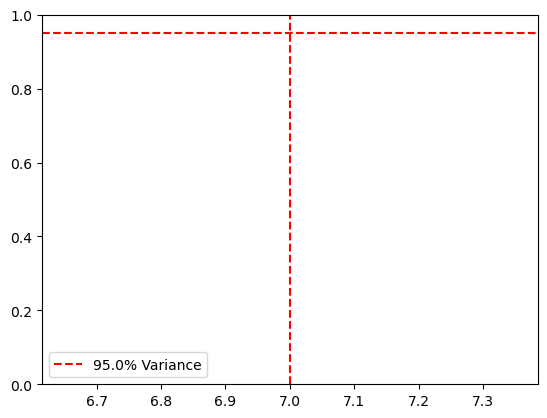

Number of components to explain 95% of variance: 7


In [27]:
# Highlight a target variance, e.g., 95%
target_variance = 0.95
num_components_95 = np.argmax(cumulative_variance >= target_variance) + 1
plt.axvline(x=num_components_95, color='r', linestyle='--', label=f'{target_variance*100}% Variance')
plt.axhline(y=target_variance, color='r', linestyle='--')
plt.legend()
plt.show()

# Find the number of components for a target variance programmatically
num_components_for_95_percent = np.argmax(pca.explained_variance_ratio_.cumsum() >= 0.95) + 1
print(f"Number of components to explain 95% of variance: {num_components_for_95_percent}")

In [29]:
# use number of components created in PCA to plot
# Create a DataFrame for the principal components for easier plotting
pca = PCA(n_components=7)
X_train_pca = pca.fit_transform(X_train) # Fit and transform training data
X_test_pca = pca.transform(X_test) # Transform the test data using the fitted PCA

pca_df = pd.DataFrame(data=X_train_pca, columns=['principal component 1', 'principal component 2',
                                                 'principal component 3', 'principal component 4',
                                                 'principal component 5', 'principal component 6',
                                                 'principal component 7'])
pca_df['target'] = y_train.values.ravel()

Explained variance ratio of the components:
[0.66071335 0.19337826 0.03539276 0.02090985 0.02052923 0.01209461
 0.01103094]
Total variance explained: 0.95


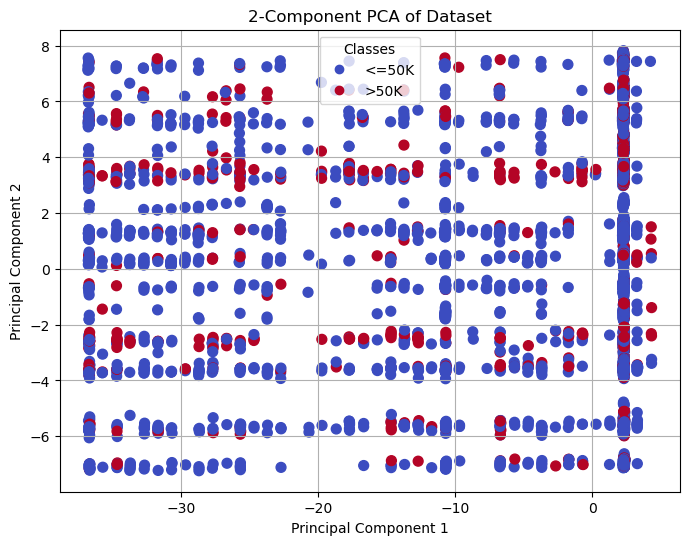

In [36]:
# Print the explained variance ratio
# This shows how much of the original data's variance is explained by each component.
print("Explained variance ratio of the components:")
print(pca.explained_variance_ratio_)
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.2f}")

# Visualize the results
# Plot the first two principal components, colored by the target class.

# Encode categorical target into integers
le = LabelEncoder()
pca_df['target_encoded'] = le.fit_transform(pca_df['target'])

# Now use the numeric encoding for coloring
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    pca_df['principal component 1'],
    pca_df['principal component 2'],
    c=pca_df['target_encoded'],
    cmap=plt.cm.coolwarm,
    s=50
)

# Build legend with class labels
handles, _ = scatter.legend_elements()
plt.legend(handles, le.classes_, title="Classes")

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2-Component PCA of Dataset')
plt.grid(True)
plt.show()

In [37]:
# Inspect the principal components_ attribute
# This shows the coefficients of the original features for each component
principal_components_matrix = pca.components_

# Create a DataFrame for better readability
component_df = pd.DataFrame(
    data=principal_components_matrix,
    columns=X.columns,
    index=['Principal Component 1', 'Principal Component 2', 
           'Principal Component 3', 'Principal Component 4', 
           'Principal Component 5', 'Principal Component 6', 
           'Principal Component 7']
)

print("Principal Component Loadings:")
print(component_df)

Principal Component Loadings:
                            age  workclass  ...  hours-per-week  native-country
Principal Component 1 -0.000669  -0.000408  ...       -0.001146        0.999815
Principal Component 2 -0.002066   0.098944  ...        0.020950        0.003965
Principal Component 3 -0.247439  -0.183168  ...       -0.224106        0.005179
Principal Component 4 -0.020881  -0.506248  ...       -0.035732        0.002386
Principal Component 5 -0.125305   0.826758  ...        0.048570        0.001672
Principal Component 6  0.043027  -0.062511  ...        0.271987       -0.005181
Principal Component 7 -0.084917   0.010475  ...       -0.003136        0.000967

[7 rows x 13 columns]


In [33]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Create and fit the GridSearchCV object with the PCA-transformed data
svc = SVC()
grid_search = GridSearchCV(svc, param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train_pca, y_train.values.ravel())

# Print the best parameters and score
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   6.4s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   6.7s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   6.9s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   6.9s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   7.1s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   7.8s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   8.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   8.2s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   5.1s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   5.3s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   5.7s
[CV] END .....................C=0.1, gamma=scale


--- Best Model Found by GridSearchCV ---
Best parameters: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Best cross-validation accuracy: 0.8372

 Final evaluation of the best model on the test set...
Final accuracy on test set: 0.8243

Classification Report:
              precision    recall  f1-score   support

       <=50K       0.85      0.93      0.89      4945
        >50K       0.70      0.48      0.57      1567

    accuracy                           0.82      6512
   macro avg       0.77      0.71      0.73      6512
weighted avg       0.81      0.82      0.81      6512


Confusion Matrix:
[[4615  330]
 [ 814  753]]


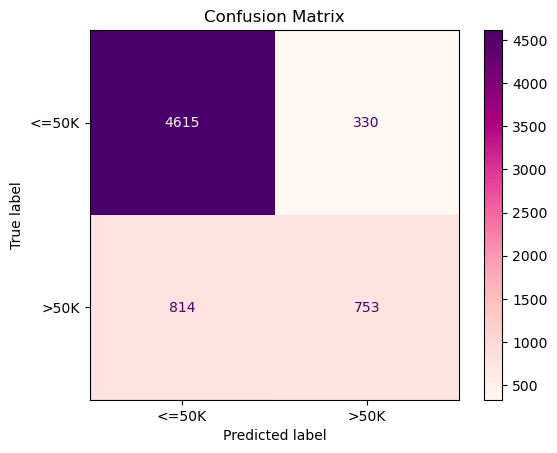

In [38]:
# Get the best estimator from the search.
best_model = grid_search.best_estimator_

print("\n--- Best Model Found by GridSearchCV ---")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

print("\n Final evaluation of the best model on the test set...")
# Predict using the best model found during the search.
final_y_pred = best_model.predict(X_test_pca)

final_accuracy = accuracy_score(y_test, final_y_pred)

print(f"Final accuracy on test set: {final_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, final_y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, final_y_pred)
print(cm)

# Plot the predictions and the confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(
    best_model,
    X_test_pca,
    y_test,
    display_labels=np.unique(y_test),  
    cmap=plt.cm.RdPu    # normalize rows to proportions
)

plt.title('Confusion Matrix')
plt.show()